In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

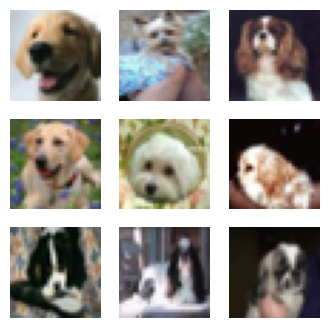

In [4]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 0, AKA Airplanes
index = np.where(y_train.reshape(-1) == 5)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -1.0, max val 0.7411764860153198
Epoch 0
Time for epoch:  29.157922506332397
loss_d=0.40407, loss_g=1.18644
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

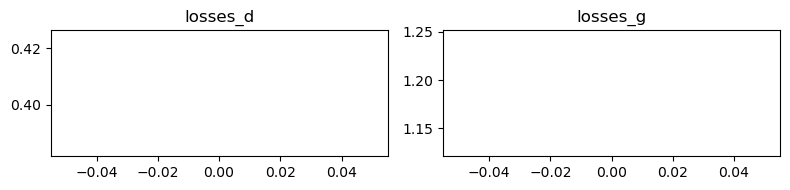

Epoch 1
Time for epoch:  26.146431922912598
Epoch 2
Time for epoch:  25.978763818740845
Epoch 3
Time for epoch:  26.174896955490112
Epoch 4
Time for epoch:  26.007198095321655
Epoch 5
Time for epoch:  26.167242288589478
loss_d=0.70143, loss_g=0.86354
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


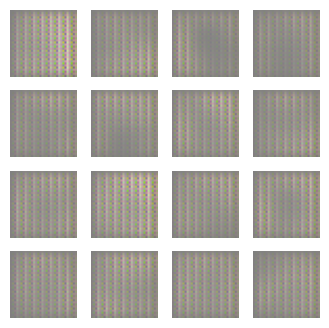

<Figure size 1600x1600 with 0 Axes>

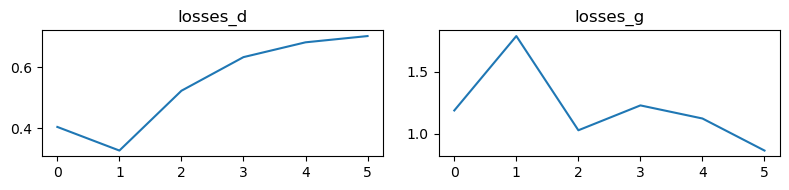

Epoch 6
Time for epoch:  25.860218286514282
Epoch 7
Time for epoch:  25.757376432418823
Epoch 8
Time for epoch:  26.2102108001709
Epoch 9
Time for epoch:  25.950299739837646
Epoch 10
Time for epoch:  25.980467319488525
loss_d=0.91364, loss_g=0.97762
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


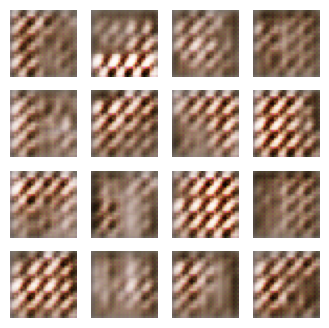

<Figure size 1600x1600 with 0 Axes>

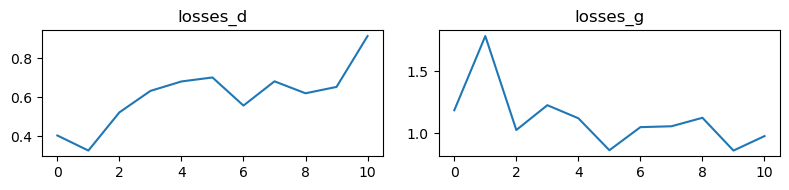

Epoch 11
Time for epoch:  25.60960626602173
Epoch 12
Time for epoch:  25.902836084365845
Epoch 13
Time for epoch:  24.375274896621704
Epoch 14
Time for epoch:  26.6315336227417
Epoch 15
Time for epoch:  25.396393537521362
loss_d=0.62937, loss_g=0.96662
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


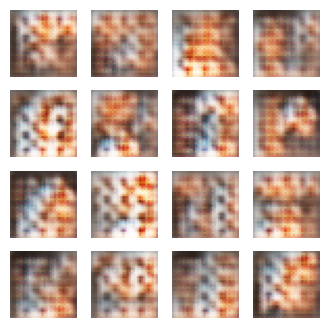

<Figure size 1600x1600 with 0 Axes>

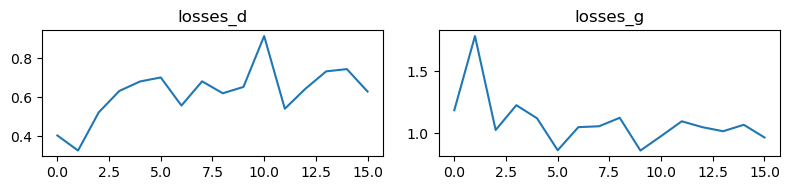

Epoch 16
Time for epoch:  25.93207097053528
Epoch 17
Time for epoch:  25.914195775985718
Epoch 18
Time for epoch:  25.798811197280884
Epoch 19
Time for epoch:  25.890595197677612
Epoch 20
Time for epoch:  25.580621004104614
loss_d=0.59956, loss_g=1.09469
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


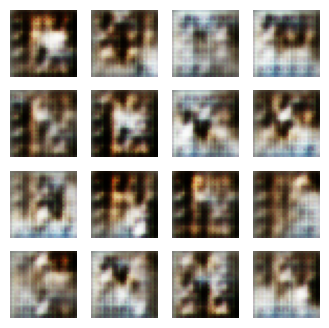

<Figure size 1600x1600 with 0 Axes>

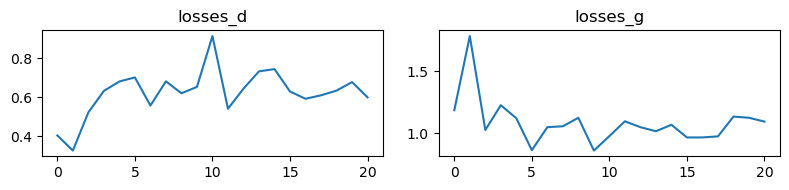

Epoch 21
Time for epoch:  23.632036924362183
Epoch 22
Time for epoch:  23.150457620620728
Epoch 23
Time for epoch:  23.101665258407593
Epoch 24
Time for epoch:  23.01751160621643
Epoch 25
Time for epoch:  23.286890268325806
loss_d=0.50334, loss_g=1.32924
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


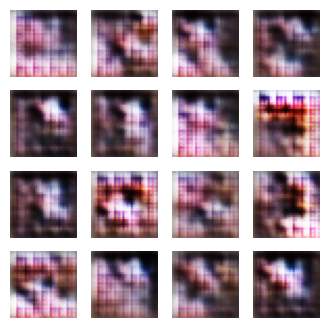

<Figure size 1600x1600 with 0 Axes>

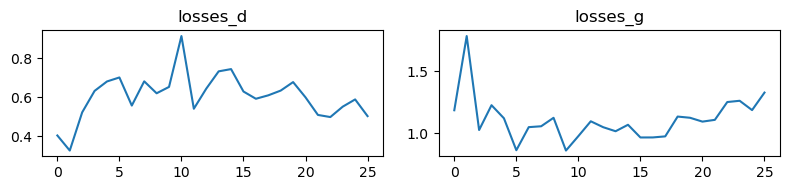

Epoch 26
Time for epoch:  22.884525775909424
Epoch 27
Time for epoch:  22.993366241455078
Epoch 28
Time for epoch:  22.872313737869263
Epoch 29
Time for epoch:  22.969826698303223
Epoch 30
Time for epoch:  23.102938175201416
loss_d=0.57697, loss_g=1.25382
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


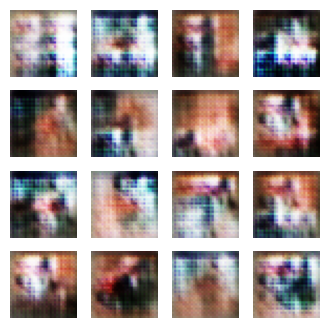

<Figure size 1600x1600 with 0 Axes>

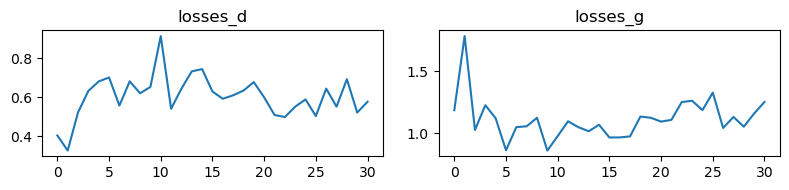

Epoch 31
Time for epoch:  22.947207927703857
Epoch 32
Time for epoch:  23.014543294906616
Epoch 33
Time for epoch:  23.36001181602478
Epoch 34
Time for epoch:  23.579353094100952
Epoch 35
Time for epoch:  26.228154182434082
loss_d=0.67395, loss_g=1.08115
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


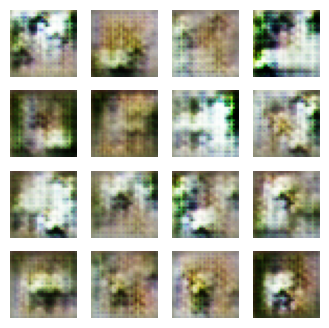

<Figure size 1600x1600 with 0 Axes>

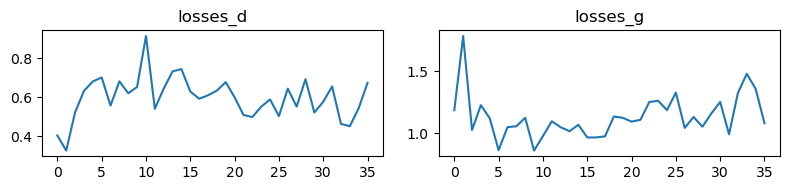

Epoch 36
Time for epoch:  26.015417098999023
Epoch 37
Time for epoch:  26.922642946243286
Epoch 38
Time for epoch:  26.151648998260498
Epoch 39
Time for epoch:  26.031944751739502
Epoch 40
Time for epoch:  26.006306409835815
loss_d=0.44122, loss_g=1.32494
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


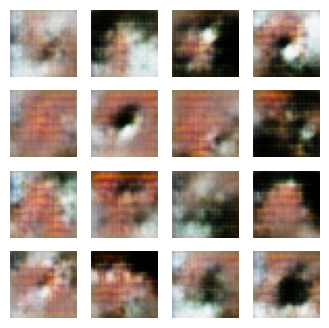

<Figure size 1600x1600 with 0 Axes>

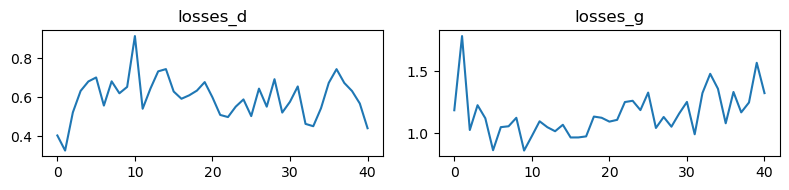

Epoch 41
Time for epoch:  26.267965078353882
Epoch 42
Time for epoch:  25.677550792694092
Epoch 43
Time for epoch:  25.839021921157837
Epoch 44
Time for epoch:  26.95066213607788
Epoch 45
Time for epoch:  26.341137647628784
loss_d=0.49256, loss_g=1.41649
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


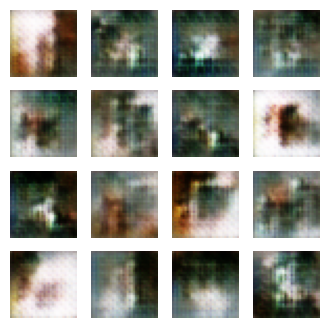

<Figure size 1600x1600 with 0 Axes>

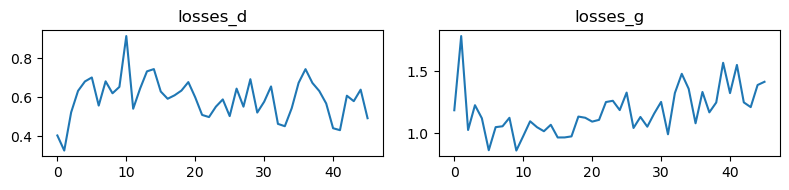

Epoch 46
Time for epoch:  26.323029041290283
Epoch 47
Time for epoch:  23.448889017105103
Epoch 48
Time for epoch:  23.477641344070435
Epoch 49
Time for epoch:  23.64488387107849
Epoch 50
Time for epoch:  23.422184467315674
loss_d=0.56133, loss_g=1.26163
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


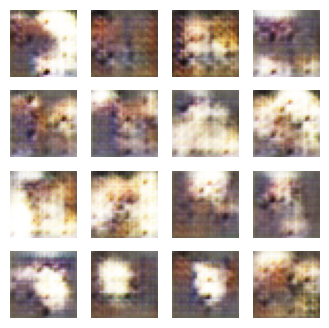

<Figure size 1600x1600 with 0 Axes>

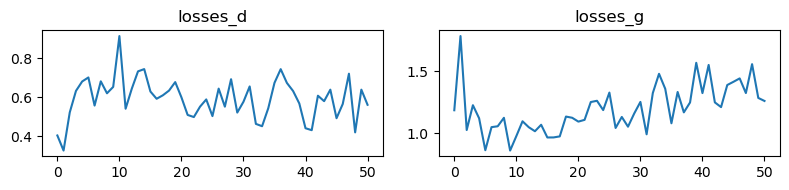

Epoch 51
Time for epoch:  23.444090604782104
Epoch 52
Time for epoch:  23.39112424850464
Epoch 53
Time for epoch:  23.593082427978516
Epoch 54
Time for epoch:  23.46208620071411
Epoch 55
Time for epoch:  24.09993577003479
loss_d=0.58323, loss_g=1.38354
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


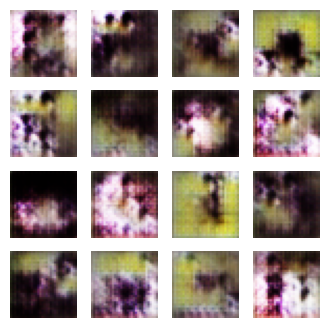

<Figure size 1600x1600 with 0 Axes>

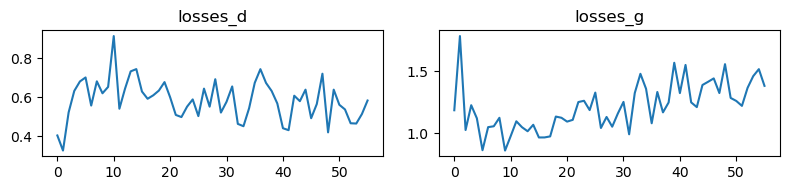

Epoch 56
Time for epoch:  24.68089270591736
Epoch 57
Time for epoch:  24.456326246261597
Epoch 58
Time for epoch:  26.894630908966064
Epoch 59
Time for epoch:  26.067760229110718
Epoch 60
Time for epoch:  26.609832525253296
loss_d=0.51344, loss_g=1.28960
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


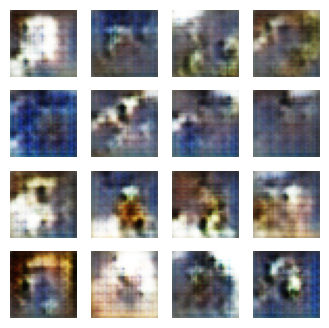

<Figure size 1600x1600 with 0 Axes>

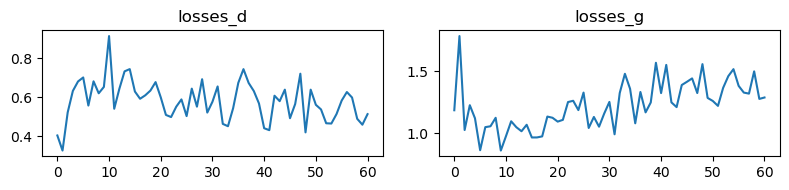

Epoch 61
Time for epoch:  26.310203313827515
Epoch 62
Time for epoch:  26.111026525497437
Epoch 63
Time for epoch:  26.150843143463135
Epoch 64
Time for epoch:  26.122036695480347
Epoch 65
Time for epoch:  26.101024866104126
loss_d=0.71708, loss_g=1.18200
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


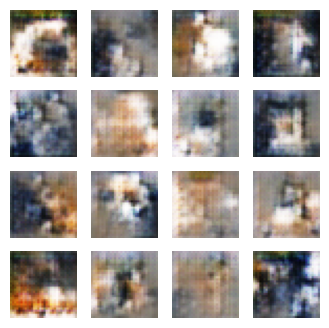

<Figure size 1600x1600 with 0 Axes>

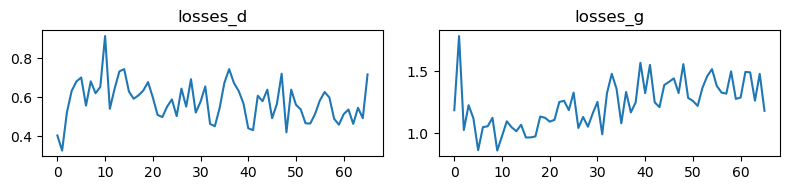

Epoch 66
Time for epoch:  26.629674434661865
Epoch 67
Time for epoch:  26.655811071395874
Epoch 68
Time for epoch:  26.096955060958862
Epoch 69
Time for epoch:  25.894855976104736
Epoch 70
Time for epoch:  26.006441831588745
loss_d=0.51458, loss_g=1.23710
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


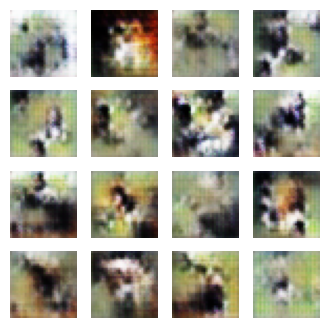

<Figure size 1600x1600 with 0 Axes>

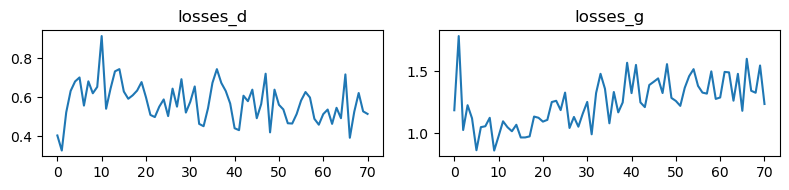

Epoch 71
Time for epoch:  26.890528917312622
Epoch 72
Time for epoch:  26.429370880126953
Epoch 73
Time for epoch:  26.75007390975952
Epoch 74
Time for epoch:  26.283249616622925
Epoch 75
Time for epoch:  26.273373126983643
loss_d=0.56065, loss_g=1.30532
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


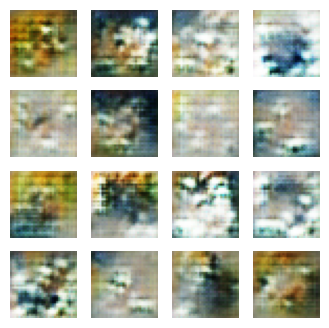

<Figure size 1600x1600 with 0 Axes>

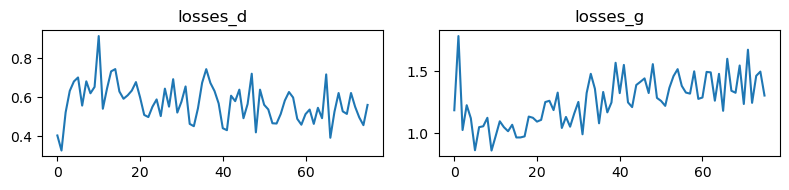

Epoch 76
Time for epoch:  26.42716383934021
Epoch 77
Time for epoch:  25.98601746559143
Epoch 78
Time for epoch:  26.76744294166565
Epoch 79
Time for epoch:  27.55310559272766
Epoch 80
Time for epoch:  24.774253606796265
loss_d=0.55882, loss_g=1.28738
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


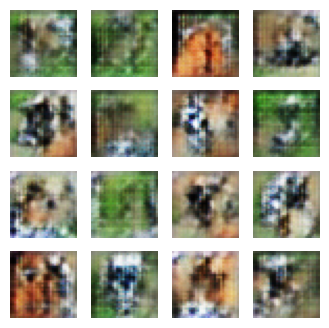

<Figure size 1600x1600 with 0 Axes>

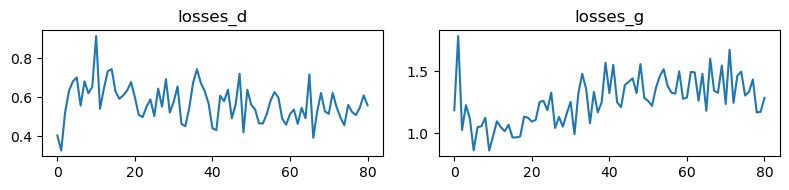

Epoch 81
Time for epoch:  23.9313063621521
Epoch 82
Time for epoch:  23.157146215438843
Epoch 83
Time for epoch:  22.81344175338745
Epoch 84
Time for epoch:  22.814510345458984
Epoch 85
Time for epoch:  22.822807788848877
loss_d=0.56648, loss_g=1.22910
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


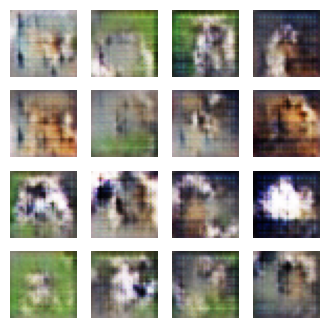

<Figure size 1600x1600 with 0 Axes>

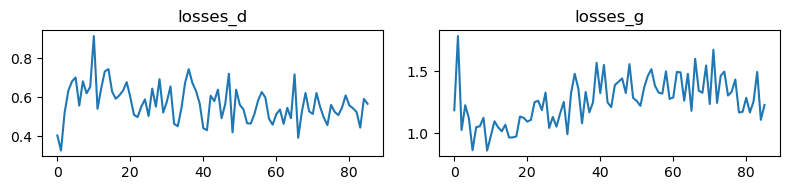

Epoch 86
Time for epoch:  22.774110794067383
Epoch 87
Time for epoch:  22.83623194694519
Epoch 88
Time for epoch:  22.79687786102295
Epoch 89
Time for epoch:  22.87571430206299
Epoch 90
Time for epoch:  22.828076124191284
loss_d=0.47161, loss_g=1.32802
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


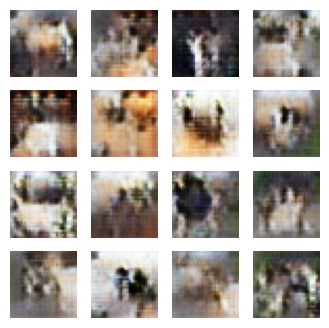

<Figure size 1600x1600 with 0 Axes>

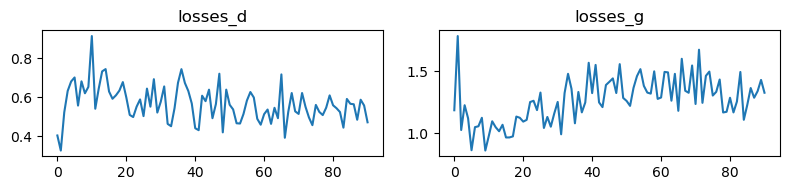

Epoch 91
Time for epoch:  23.387134552001953
Epoch 92
Time for epoch:  26.26810097694397
Epoch 93
Time for epoch:  26.101415872573853
Epoch 94
Time for epoch:  26.1735098361969
Epoch 95
Time for epoch:  26.055091381072998
loss_d=0.63307, loss_g=1.14586
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


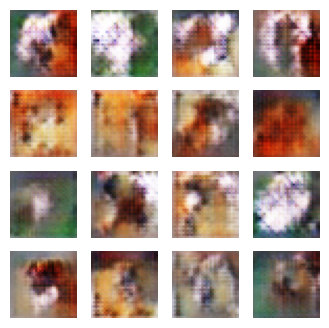

<Figure size 1600x1600 with 0 Axes>

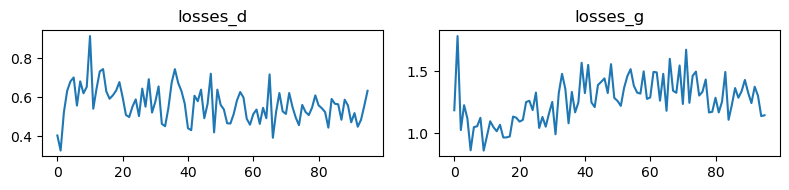

Epoch 96
Time for epoch:  26.001036167144775
Epoch 97
Time for epoch:  26.446444988250732
Epoch 98
Time for epoch:  26.261486530303955
Epoch 99
Time for epoch:  26.076547861099243
Epoch 100
Time for epoch:  25.870391607284546
loss_d=0.58103, loss_g=1.18775
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


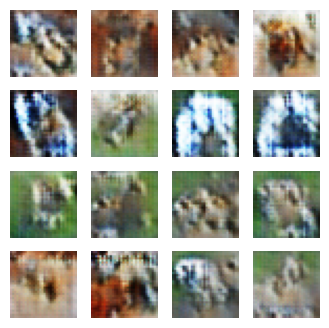

<Figure size 1600x1600 with 0 Axes>

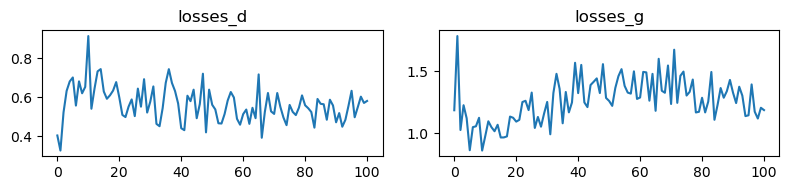

Epoch 101
Time for epoch:  25.852214336395264
Epoch 102
Time for epoch:  26.260619401931763
Epoch 103
Time for epoch:  26.645567417144775
Epoch 104
Time for epoch:  26.567764043807983
Epoch 105
Time for epoch:  26.201444625854492
loss_d=0.53547, loss_g=1.34072
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


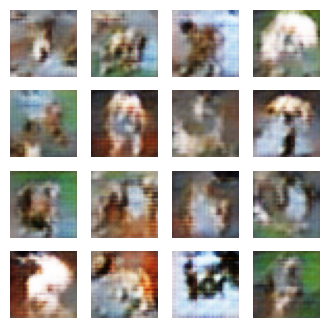

<Figure size 1600x1600 with 0 Axes>

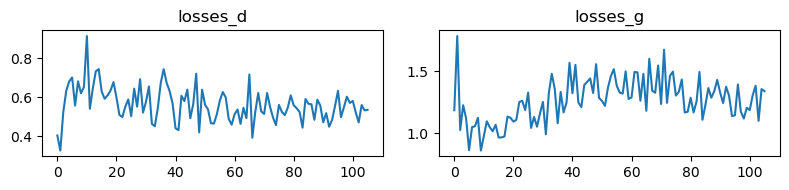

Epoch 106
Time for epoch:  26.48699450492859
Epoch 107
Time for epoch:  26.312537670135498
Epoch 108
Time for epoch:  25.979984998703003
Epoch 109
Time for epoch:  26.575681686401367
Epoch 110
Time for epoch:  26.45991063117981
loss_d=0.51982, loss_g=1.17494
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


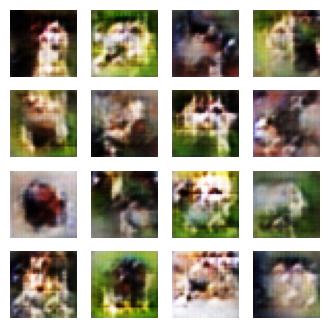

<Figure size 1600x1600 with 0 Axes>

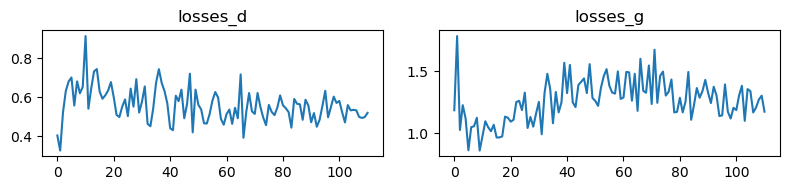

Epoch 111
Time for epoch:  26.461409091949463
Epoch 112
Time for epoch:  27.02083945274353
Epoch 113
Time for epoch:  26.633201599121094
Epoch 114
Time for epoch:  26.496118783950806
Epoch 115
Time for epoch:  26.51829695701599
loss_d=0.49269, loss_g=1.25191
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


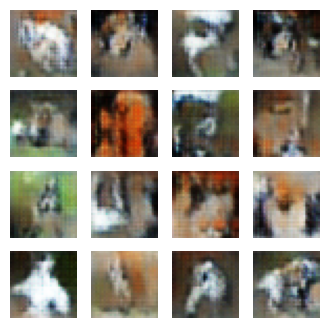

<Figure size 1600x1600 with 0 Axes>

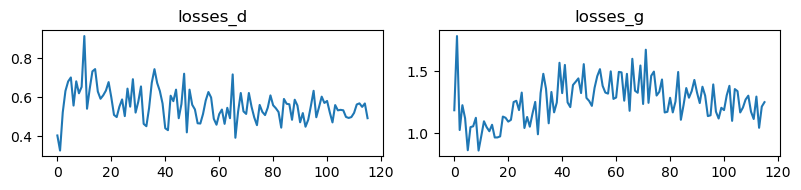

Epoch 116
Time for epoch:  26.66866159439087
Epoch 117
Time for epoch:  25.637863636016846
Epoch 118
Time for epoch:  26.15805220603943
Epoch 119
Time for epoch:  26.45391869544983
Epoch 120
Time for epoch:  26.481022357940674
loss_d=0.54868, loss_g=1.19916
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


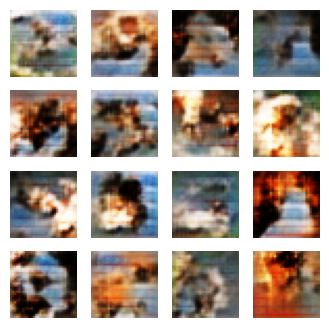

<Figure size 1600x1600 with 0 Axes>

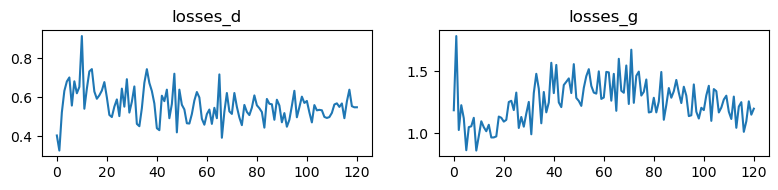

Epoch 121
Time for epoch:  26.19131851196289
Epoch 122
Time for epoch:  26.049156188964844
Epoch 123
Time for epoch:  26.28469467163086
Epoch 124
Time for epoch:  26.383697032928467
Epoch 125
Time for epoch:  26.536684036254883
loss_d=0.55479, loss_g=1.11474
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


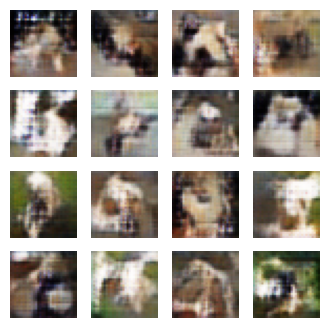

<Figure size 1600x1600 with 0 Axes>

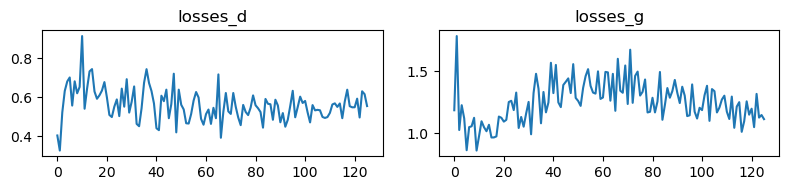

Epoch 126
Time for epoch:  26.607542514801025
Epoch 127
Time for epoch:  26.61455225944519
Epoch 128
Time for epoch:  26.467504262924194
Epoch 129
Time for epoch:  26.59426212310791
Epoch 130
Time for epoch:  26.341989278793335
loss_d=0.53173, loss_g=1.12838
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


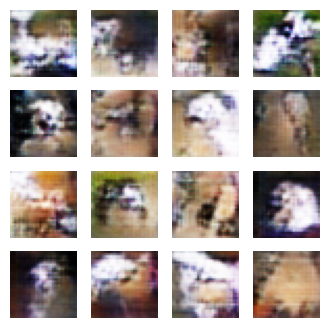

<Figure size 1600x1600 with 0 Axes>

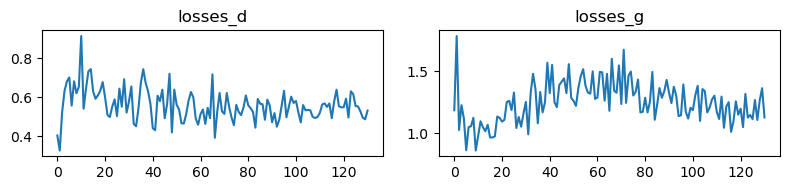

Epoch 131
Time for epoch:  26.300352811813354
Epoch 132
Time for epoch:  26.367004871368408
Epoch 133
Time for epoch:  26.559749126434326
Epoch 134
Time for epoch:  26.312008142471313
Epoch 135
Time for epoch:  24.204829692840576
loss_d=0.52192, loss_g=1.26603
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


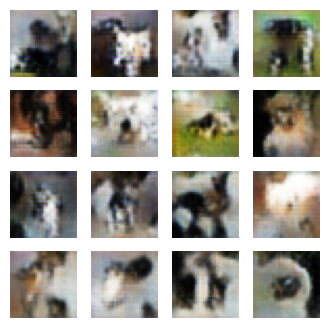

<Figure size 1600x1600 with 0 Axes>

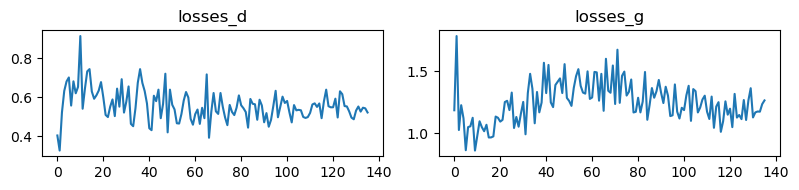

Epoch 136
Time for epoch:  22.98627471923828
Epoch 137
Time for epoch:  22.928802251815796
Epoch 138
Time for epoch:  23.113773584365845
Epoch 139
Time for epoch:  22.828555583953857
Epoch 140
Time for epoch:  22.959550619125366
loss_d=0.56745, loss_g=1.18027
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


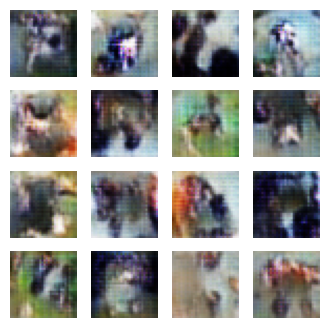

<Figure size 1600x1600 with 0 Axes>

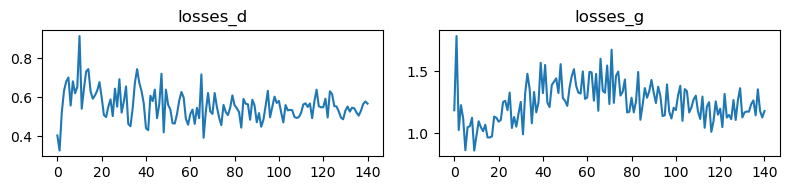

Epoch 141
Time for epoch:  23.462614059448242
Epoch 142
Time for epoch:  23.104244232177734
Epoch 143
Time for epoch:  23.154663801193237
Epoch 144
Time for epoch:  22.859828233718872
Epoch 145
Time for epoch:  22.93310832977295
loss_d=0.47413, loss_g=1.35850
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


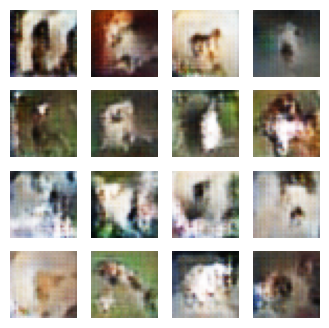

<Figure size 1600x1600 with 0 Axes>

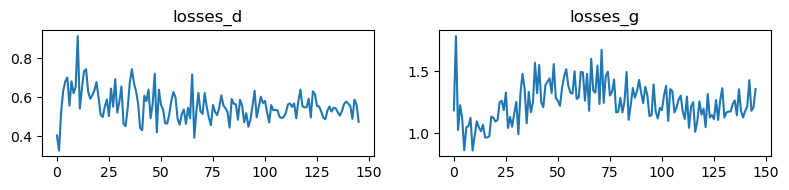

Epoch 146
Time for epoch:  23.385669946670532
Epoch 147
Time for epoch:  23.478692293167114
Epoch 148
Time for epoch:  25.022804260253906
Epoch 149
Time for epoch:  23.568421602249146


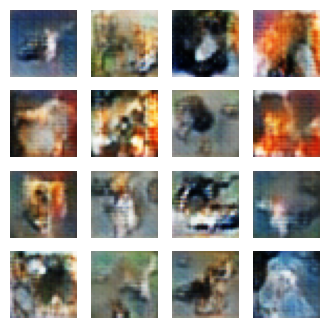

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab dogs
    index = np.where(y_train.reshape(-1) == 5)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_dogs_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

4/4 [==============================] - 0s 9ms/step


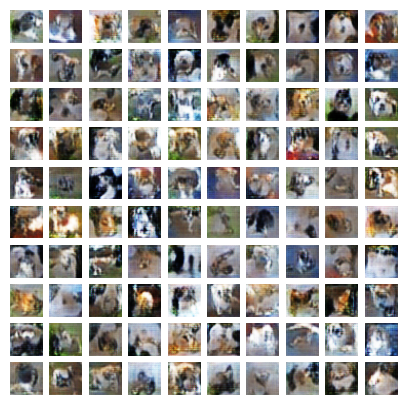

In [6]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 9ms/step


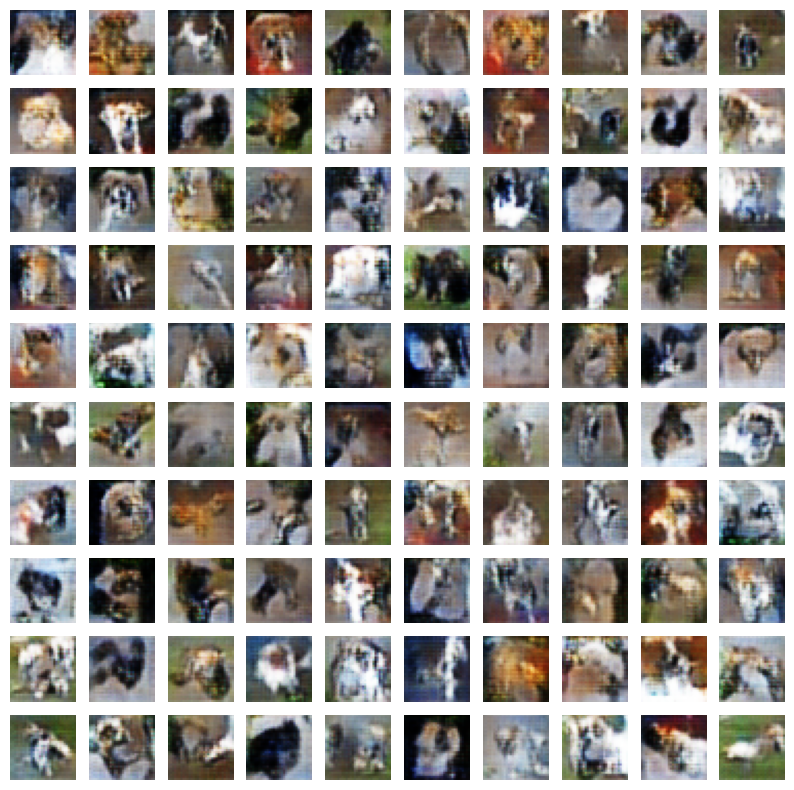

In [11]:
# #Print example images 
#Default Sets, 250 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1